# 2-3 Vertex AI pipeline - AutoML with clients in automated pipeline

The pipeline will create a dataset, then create an AutoML model, create an endpoint and deploy our model to that. Then we can interact with the deployed model, which is our asset, and get predictions from it

# Setup

In [2]:
REGION = 'europe-west1'
PROJECT_ID = 'llmops-452409'
DATANAME = 'fraud'
NOTEBOOK = '2-3'
BUCKET = 'llmops-zeinab-123'

# Resources
DEPLOY_COMPUTE = 'n1-standard-4'

# Model Training
VAR_TARGET = 'Class'
VAR_OMIT = 'transaction_id'

In [3]:
from google.cloud import aiplatform, bigquery
from datetime import datetime
from kfp import compiler, dsl #Kubeflow pipeline to build the pipeline in Vertex AI
from google.protobuf import json_format
from google.protobuf.struct_pb2 import Value
import json
import numpy as np

In [4]:
aiplatform.init(project=PROJECT_ID,location=REGION)
bigquery = bigquery.Client()

In [23]:
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
URI = f"gs://{BUCKET}/{DATANAME}/models/{NOTEBOOK}"
DIR = f"temp/{NOTEBOOK}"

Note: Give the role storage.objectAdmin to service account printed below via GCP Console

In [5]:
SERVICE_ACCOUNT = !gcloud config list --format='value(core.account)'
SERVICE_ACCOUNT = SERVICE_ACCOUNT[0]
SERVICE_ACCOUNT

'200042228144-compute@developer.gserviceaccount.com'

environment: start from a fresh temp directory

In [6]:
!rm -rf {DIR}
!mkdir -p {DIR}

## Define the Pipeline
We don't need to containerize the components, KFP will take care of that :)
NOTE: Make sure to set the locations properly, otherwise the job will fail. Dataset, training job, etc need to be in the same region.

In [13]:
from google_cloud_pipeline_components.v1.automl.training_job import AutoMLTabularTrainingJobRunOp
from google_cloud_pipeline_components.v1.dataset.create_tabular_dataset.component import tabular_dataset_create as TabularDatasetCreateOp
from google_cloud_pipeline_components.v1.endpoint.create_endpoint.component import endpoint_create as EndpointCreateOp
from google_cloud_pipeline_components.v1.endpoint.deploy_model.component import model_deploy as ModelDeployOp

@dsl.pipeline(name = f'kfp-{NOTEBOOK}-{DATANAME}-{TIMESTAMP}', pipeline_root = URI+'/'+str(TIMESTAMP)+'/kfp/')
def pipeline(
    project: str = PROJECT_ID,
    dataname: str=DATANAME,
    display_name: str=f'{NOTEBOOK}-{DATANAME}-{TIMESTAMP}',
    deploy_machine: str = DEPLOY_COMPUTE,
    bq_source: str = f'bq://{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped',
    var_target: str = VAR_TARGET,
    var_omit: str = VAR_OMIT,
    location: str= REGION,
    label: str = NOTEBOOK
):
    
    #1st component
    #dataset
    display_name_filter = f"{NOTEBOOK}-{DATANAME}-{TIMESTAMP}"
    existing_datasets = aiplatform.TabularDataset.list(filter=f"display_name={display_name_filter}")
    # if existing_datasets:
    #     dataset = existing_datasets[0]
    #     print(f"Using existing dataset: {dataset.display_name}")
    # else:
    dataset = TabularDatasetCreateOp(
        project = project,
        display_name = display_name,
        bq_source = bq_source,
        location=location,
        labels = {'notebook':f'{NOTEBOOK}'}
    ).outputs["dataset"]
    print(f"Created new dataset: {dataset}")
    
    #get feature names
    from google.cloud import bigquery
    bigquery = bigquery.Client(project = PROJECT_ID)
    # get all the column names from our dataset
    query = f"SELECT * FROM {DATANAME}.INFORMATION_SCHEMA.COLUMNS WHERE TABLE_NAME = '{DATANAME}_prepped'"
    schema = bigquery.query(query).to_dataframe()
    # remove transaction id, target variable, and splits columns
    OMIT = VAR_OMIT.split() + [VAR_TARGET, 'splits']
    #build the list of features from the list of column names
    features = schema[~schema.column_name.isin(OMIT)].column_name.tolist()
    features = dict.fromkeys(features, 'auto')
    
   # AutoML tabular training job
    # Check if the model already exists
    # existing_models = aiplatform.Model.list(
    #     filter=f"display_name={display_name_filter}",
    #     order_by="update_time desc"
    # )

    # if existing_models:
    #     model = existing_models[0]  # Use the latest existing model
    #     print(f"Using existing model: {model.display_name}")
    # else:
    #     # Train a new model if no existing one is found
    model = AutoMLTabularTrainingJobRunOp(
        project = project,
        location=location,
        display_name = display_name,
        optimization_prediction_type = "classification",
        optimization_objective = 'maximize-au-prc',
        budget_milli_node_hours = 2000,#i.e. 2 hours
        disable_early_stopping=False, #enable early stopping if the model does not get better
        column_specs = features,
        dataset = dataset,
        target_column = var_target,
        predefined_split_column_name = 'splits',
        labels = {'notebook':f'{NOTEBOOK}'}        
    ).outputs["model"]
    print(f"Trained new model: {model}")
    
    # Endpoint: Creation
    # Check if the endpoint already exists
    # existing_endpoints = aiplatform.Endpoint.list(
    #     filter=f"display_name={display_name_filter}",
    #     order_by="update_time desc"
    # )

    # if existing_endpoints:
    #     endpoint = existing_endpoints[0]  # Use the latest existing endpoint
    #     print(f"Using existing endpoint: {endpoint.display_name}")
    # else:
        #Create a new endpoint if none exist
    endpoint = EndpointCreateOp(
        project = project,
        location=location,
        display_name = display_name,
        labels = {'notebook':f'{label}'}
    ).outputs["endpoint"]
    print(f"Created new endpoint: {endpoint}")
    
    # Endpoint: Deployment of Model
    # TODO: check if an endpoint already exists
    deployment = ModelDeployOp(
        model = model,
        endpoint = endpoint,
        dedicated_resources_min_replica_count =1,
        dedicated_resources_max_replica_count = 1,
        traffic_split = {"0": 100},
        dedicated_resources_machine_type = deploy_machine
    )
    

Created new dataset: {{channel:task=tabular-dataset-create;name=dataset;type=google.VertexDataset@0.0.1;}}


/opt/conda/envs/tensorflow/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2309: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/envs/tensorflow/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2323: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/envs/tensorflow/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2337: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)


Trained new model: {{channel:task=automl-tabular-training-job;name=model;type=google.VertexModel@0.0.1;}}
Created new endpoint: {{channel:task=endpoint-create;name=endpoint;type=google.VertexEndpoint@0.0.1;}}


## Compile Pipeline

In [14]:
compiler.Compiler().compile(
    pipeline_func = pipeline,
    package_path = f"{DIR}/{NOTEBOOK}.json"
)

Move compiled pipeline files to GCS Bucket

In [15]:
!gsutil cp {DIR}/{NOTEBOOK}.json {URI}/{TIMESTAMP}/kfp/

Copying file://temp/2-3/2-3.json [Content-Type=application/json]...
/ [1 files][ 49.0 KiB/ 49.0 KiB]                                                
Operation completed over 1 objects/49.0 KiB.                                     


## Create Vertex AI Pipeline Job

In [16]:
pipeline = aiplatform.PipelineJob(
    display_name = f'{NOTEBOOK}_{DATANAME}_{TIMESTAMP}',
    template_path= f"{URI}/{TIMESTAMP}/kfp/{NOTEBOOK}.json",
    pipeline_root= f"{URI}/{TIMESTAMP}/kfp/",
    labels= {'notebook': f'{NOTEBOOK}'},    
    enable_caching = True # this is for caching the completed steps of the pipeline and is useful for resuming when there is an error
)

In [ ]:
response = pipeline.run(service_account = SERVICE_ACCOUNT)

Creating PipelineJob
PipelineJob created. Resource name: projects/200042228144/locations/europe-west1/pipelineJobs/kfp-2-3-fraud-20250306094814-20250306132216
To use this PipelineJob in another session:
pipeline_job = aiplatform.PipelineJob.get('projects/200042228144/locations/europe-west1/pipelineJobs/kfp-2-3-fraud-20250306094814-20250306132216')
View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/europe-west1/pipelines/runs/kfp-2-3-fraud-20250306094814-20250306132216?project=200042228144
PipelineJob projects/200042228144/locations/europe-west1/pipelineJobs/kfp-2-3-fraud-20250306094814-20250306132216 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/200042228144/locations/europe-west1/pipelineJobs/kfp-2-3-fraud-20250306094814-20250306132216 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/200042228144/locations/europe-west1/pipelineJobs/kfp-2-3-fraud-20250306094814-20250306132216 current state:
PipelineState.PIPELINE_S

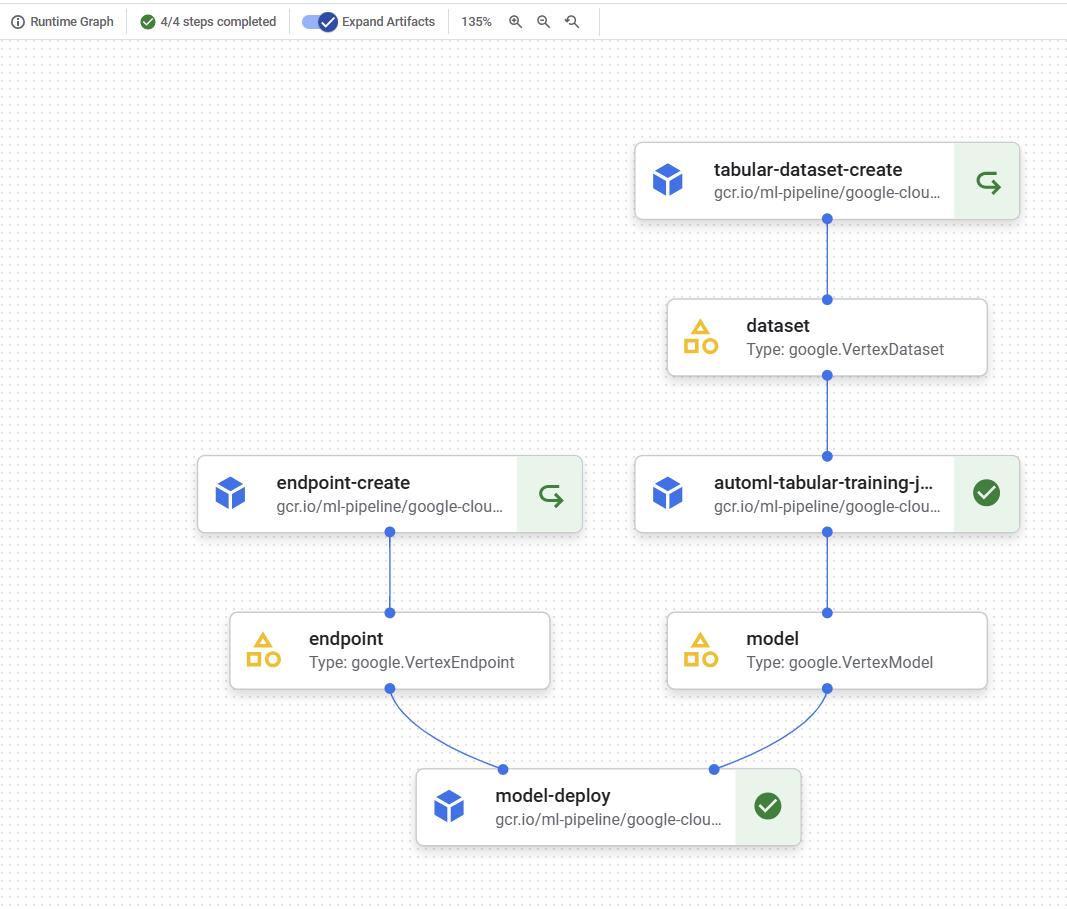

In [6]:
# aiplatform.get_pipeline_df(pipeline ="kfp-2-3-fraud-20250306094814-20250306132216")

## Prediction

Prepare a record for prediction: instance and paramers lists

In [17]:
pred = bigquery.query(query = f"SELECT * FROM {DATANAME}.{DATANAME}_prepped WHERE splits ='TEST' and Class=1 LIMIT 10").to_dataframe()
pred.head()

/opt/conda/envs/tensorflow/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2309: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/envs/tensorflow/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2323: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/envs/tensorflow/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2337: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,transaction_id,splits
0,125658,0.224414,2.994499,-3.432458,3.986519,3.760233,0.165640,1.099378,-0.654557,-2.435416,...,-0.421979,-1.048058,0.726412,0.268625,0.283689,0.419102,0.00,1,fc4b2fac-69e2-4460-bb8a-701e3c679be2,TEST
1,85285,-7.030308,3.421991,-9.525072,5.270891,-4.024630,-2.865682,-6.989195,3.791551,-4.622730,...,0.036943,-0.355519,0.353634,1.042458,1.359516,-0.272188,0.00,1,83f7f41d-01f8-4927-b491-b0d75a0dbf02,TEST
2,142961,0.457845,1.373769,-0.488926,2.805351,1.777386,0.100492,1.295016,-0.135857,-1.695822,...,0.051105,0.401524,-0.724766,-0.202881,0.092124,0.094956,0.00,1,236bc56a-7162-4f0b-8f2d-6043465364a8,TEST
3,93834,-3.765680,5.890735,-10.202268,10.259036,-5.611448,-3.235376,-10.632683,3.272716,-5.268905,...,0.381853,0.382025,-0.821036,0.394355,1.412961,0.782407,0.01,1,bbb9bb66-30ae-4181-8a77-6dac8c1b3b67,TEST
4,29531,-1.060676,2.608579,-2.971679,4.360089,3.738853,-2.728395,1.987616,-0.357345,-2.757535,...,-0.183261,-0.103679,0.896178,0.407387,-0.130918,0.192177,0.68,1,4d00994a-9691-4f92-a905-afe61f2c0a81,TEST


Remove extra columns

In [18]:
newob = pred[pred.columns[~pred.columns.isin(VAR_OMIT.split()+[VAR_TARGET, 'splits'])]].to_dict(orient='records')[4]
newob['Time'] = str(newob['Time'])
#structured version of the transaction which is required by the endpoint
instances = [json_format.ParseDict(newob, Value())]
parameters = json_format.ParseDict({},Value())

## Get predictions using a Python Client
Pick the right endpoint and ask for a prediction

In [19]:
endpoint = aiplatform.Endpoint.list(filter='display_name=2-3-fraud-20250306094814')[0]
endpoint.display_name

'2-3-fraud-20250306094814'

In [20]:
prediction = endpoint.predict(instances=instances, parameters=parameters)
prediction

Prediction(predictions=[{'classes': ['0', '1'], 'scores': [0.1106203943490982, 0.8893795609474182]}], deployed_model_id='8679909827524165632', metadata=None, model_version_id='1', model_resource_name='projects/200042228144/locations/europe-west1/models/8459717230899232768', explanations=None)

In [21]:
prediction.predictions[0]['classes'][np.argmax(prediction.predictions[0]['scores'])]

'1'

## Get predictions using REST
Dump request instances into a json file

In [24]:
with open(f'{DIR}/request.json','w') as file:
    file.write(json.dumps({"instances":[newob]}))

In [25]:
!curl -X POST \
-H "Authorization: Bearer "$(gcloud auth application-default print-access-token) \
-H "Content-Type: application/json; charset=utf-8" \
-d @{DIR}/request.json \
https://{REGION}-aiplatform.googleapis.com/v1/{endpoint.resource_name}:predict

{
  "predictions": [
    {
      "scores": [
        0.11062039434909821,
        0.88937956094741821
      ],
      "classes": [
        "0",
        "1"
      ]
    }
  ],
  "deployedModelId": "8679909827524165632",
  "model": "projects/200042228144/locations/europe-west1/models/8459717230899232768",
  "modelDisplayName": "2-3-fraud-20250306094814",
  "modelVersionId": "1"
}


## Get predictions using gcloud CLI

In [26]:
!gcloud beta ai endpoints predict {endpoint.name.rsplit('/',1)[-1]} --region={REGION} --json-request={DIR}/request.json

Using endpoint [https://europe-west1-prediction-aiplatform.googleapis.com/]
[{'classes': ['0', '1'], 'scores': [0.1106203943490982, 0.8893795609474182]}]


## Batch Predictions: BigQuery Source to BigQuery Destination, with Explanations
This takes a couple of hours to generate predictions for all the records.

In [27]:
batch = aiplatform.BatchPredictionJob.create(
    job_display_name = f'{NOTEBOOK}_{DATANAME}_{TIMESTAMP}',
    model_name = endpoint.list_models()[0].model,
    instances_format = "bigquery",
    predictions_format="bigquery",
    bigquery_source = f'bq://{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped',
    bigquery_destination_prefix = f"{PROJECT_ID}",
    generate_explanation = True,
    labels= {'notebook':f'{NOTEBOOK}'}
)

Creating BatchPredictionJob
BatchPredictionJob created. Resource name: projects/200042228144/locations/europe-west1/batchPredictionJobs/4827816881660362752
To use this BatchPredictionJob in another session:
bpj = aiplatform.BatchPredictionJob('projects/200042228144/locations/europe-west1/batchPredictionJobs/4827816881660362752')
View Batch Prediction Job:
https://console.cloud.google.com/ai/platform/locations/europe-west1/batch-predictions/4827816881660362752?project=200042228144
BatchPredictionJob projects/200042228144/locations/europe-west1/batchPredictionJobs/4827816881660362752 current state:
JobState.JOB_STATE_RUNNING
BatchPredictionJob projects/200042228144/locations/europe-west1/batchPredictionJobs/4827816881660362752 current state:
JobState.JOB_STATE_RUNNING
BatchPredictionJob projects/200042228144/locations/europe-west1/batchPredictionJobs/4827816881660362752 current state:
JobState.JOB_STATE_RUNNING
BatchPredictionJob projects/200042228144/locations/europe-west1/batchPredicti

Let's first retrieve the endpoint if it's null because kernel was reset

In [28]:
explanation = endpoint.explain(instances=instances, parameters = parameters)
explanation.predictions

[{'classes': ['0', '1'], 'scores': [0.1106203943490982, 0.8893795609474182]}]

In [29]:
print("attribution:")
print("baseline output",explanation.explanations[0].attributions[0].baseline_output_value)
print("instance output",explanation.explanations[0].attributions[0].instance_output_value)
print("output index",explanation.explanations[0].attributions[0].output_index)
print("output display value",explanation.explanations[0].attributions[0].output_display_name)
print("approximation error",explanation.explanations[0].attributions[0].approximation_error)

attribution:
baseline output 1.6943846276262775e-05
instance output 0.8893795609474182
output index [1]
output display value 1
approximation error 0.013172983047771179


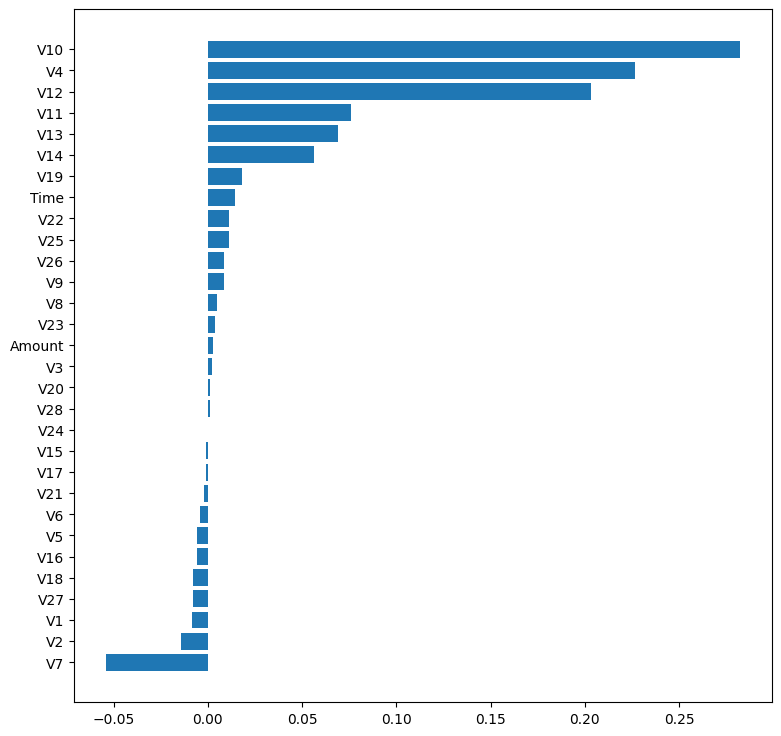

In [30]:
import matplotlib.pyplot as plt
features=[]
scores = []
for k in explanation.explanations[0].attributions[0].feature_attributions:
    features.append(k)
    scores.append(explanation.explanations[0].attributions[0].feature_attributions[k])
features = [x for _, x in sorted(zip(scores, features))]
scores = sorted(scores)
fig, ax = plt.subplots()
fig.set_size_inches(9,9)
ax.barh(features,scores)
fig.show()

## Retrieve the Confusion matrix through the API
The first step would be to retrieve the model if we are not in the same session as the one that created the model

In [31]:
def get_model_by_name(model_name):
    aiplatform.init(project=PROJECT_ID, location=REGION)
    # Retrieve the model using its name
    model = aiplatform.Model(model_name=model_name)

    return model
model = get_model_by_name("4252229279028346880")

In [32]:
model.resource_name

'projects/200042228144/locations/europe-west1/models/4252229279028346880'

In [33]:
model_client = aiplatform.gapic.ModelServiceClient(
    client_options = {
        'api_endpoint' : f'{REGION}-aiplatform.googleapis.com'
    }
)

In [34]:
evaluations = model_client.list_model_evaluations(parent = model.resource_name)
evals = iter(evaluations)
eval_id = next(evals).name
geteval = model_client.get_model_evaluation(name = eval_id)

Review several of the metrics included in the evaluation. Also, you can compare these to the results in the console view

In [35]:
geteval.metrics['auPrc']

0.9996297

In [36]:
for i in range(len(geteval.metrics['confusionMatrix']['annotationSpecs'])):
    true_label = geteval.metrics['confusionMatrix']['annotationSpecs'][i]['displayName']
    predicted_labels = geteval.metrics['confusionMatrix']['rows'][i]
    print(f'True Label = {true_label} has predicted labels = {predicted_labels}')

True Label = 0 has predicted labels = [28441.0, 2.0, 0.0]
True Label = 1 has predicted labels = [13.0, 34.0, 0.0]
True Label = DROPPED has predicted labels = [0.0, 0.0, 0.0]


In [37]:
slices = model_client.list_model_evaluation_slices(parent= eval_id)

Print value of the area under precision curve 

In [38]:
for slice in slices:
    print('Label = ', slice.slice_.value, 'has auPrc= ', slice.metrics['auPrc'])

Label =  1 has auPrc=  0.7954801
Label =  0 has auPrc=  0.99971676


## Remove resources!